Import dependencies

In [1]:
import pandas as pd
import numpy as np
import pickle

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Concatenate

from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Embedding, Bidirectional, TimeDistributed, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Dropout
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import time

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.list_physical_devices('GPU') 

[]

Load the dataset from the original publication

In [3]:
DF_MRI = pd.read_excel(open('./datasets/Our Dataset.xlsx', 'rb'),
              sheet_name='Data organized fluoro-monomer')  

In [4]:
DF_MRI

,VPA,QJ2,QJ3,FDH3,LX,ZDH1,T50
0,0.46,0.00,0.08,0.0,0.00,0.46,609
1,0.26,0.00,0.60,0.0,0.00,0.14,629
2,0.61,0.00,0.21,0.0,0.00,0.18,570
3,0.75,0.00,0.13,0.0,0.00,0.12,492
4,0.15,0.00,0.74,0.0,0.00,0.11,540
...,...,...,...,...,...,...,...
175,0.26,0.47,0.00,0.0,0.27,0.00,523
176,0.16,0.24,0.00,0.0,0.60,0.00,400
177,0.13,0.37,0.00,0.0,0.50,0.00,420
178,0.13,0.50,0.00,0.0,0.37,0.00,427


Construct the summary table

In [5]:
VPA = 'C=CP(=O)(O)O'
QJ2 = 'C=CC(=O)N'
QJ3 = 'C=CC(=O)NC(CO)(CO)CO'
FDH3 = 'CC(C)(CS(=O)(=O)O)NC(=O)C=C'
LX = 'CC(=C)C(=O)OCCOP(=O)([O-])OCC[N+](C)(C)C'
ZDH1 = 'C[N+](C)(C)CCOC(=O)C=C.[Cl-]'

In [6]:
Flag = [i != 'X' for i in DF_MRI['T50']]

In [7]:
DF_MRI[Flag]

,VPA,QJ2,QJ3,FDH3,LX,ZDH1,T50
0,0.46,0.00,0.08,0.0,0.00,0.46,609
1,0.26,0.00,0.60,0.0,0.00,0.14,629
2,0.61,0.00,0.21,0.0,0.00,0.18,570
3,0.75,0.00,0.13,0.0,0.00,0.12,492
4,0.15,0.00,0.74,0.0,0.00,0.11,540
...,...,...,...,...,...,...,...
175,0.26,0.47,0.00,0.0,0.27,0.00,523
176,0.16,0.24,0.00,0.0,0.60,0.00,400
177,0.13,0.37,0.00,0.0,0.50,0.00,420
178,0.13,0.50,0.00,0.0,0.37,0.00,427


In [8]:
Dataset_2 = DF_MRI[Flag].copy()

In [9]:
Dataset_2['Smiles'] = np.nan
for i in range(len(Dataset_2)):
    smi = 'C'
    if Dataset_2.loc[i, 'VPA'] > 0:
        smi = smi + '.C=CP(=O)(O)O'
    if Dataset_2.loc[i, 'QJ2'] > 0:
        smi = smi + '.C=CC(=O)N'
    if Dataset_2.loc[i, 'QJ3'] > 0:
        smi = smi + '.C=CC(=O)NC(CO)(CO)CO'
    if Dataset_2.loc[i, 'FDH3'] > 0:
        smi = smi + '.CC(C)(CS(=O)(=O)O)NC(=O)C=C'
    if Dataset_2.loc[i, 'LX'] > 0:
        smi = smi + '.CC(=C)C(=O)OCCOP(=O)([O-])OCC[N+](C)(C)C'
    if Dataset_2.loc[i, 'ZDH1'] > 0:
        smi = smi + '.C[N+](C)(C)CCOC(=O)C=C.[Cl-]'
    Dataset_2.loc[i, 'Smiles'] = smi

In [10]:
Dataset_2

,VPA,QJ2,QJ3,FDH3,LX,ZDH1,T50,Smiles
0,0.46,0.00,0.08,0.0,0.00,0.46,609,C.C=CP(=O)(O)O.C=CC(=O)NC(CO)(CO)CO.C[N+](C)(C...
1,0.26,0.00,0.60,0.0,0.00,0.14,629,C.C=CP(=O)(O)O.C=CC(=O)NC(CO)(CO)CO.C[N+](C)(C...
2,0.61,0.00,0.21,0.0,0.00,0.18,570,C.C=CP(=O)(O)O.C=CC(=O)NC(CO)(CO)CO.C[N+](C)(C...
3,0.75,0.00,0.13,0.0,0.00,0.12,492,C.C=CP(=O)(O)O.C=CC(=O)NC(CO)(CO)CO.C[N+](C)(C...
4,0.15,0.00,0.74,0.0,0.00,0.11,540,C.C=CP(=O)(O)O.C=CC(=O)NC(CO)(CO)CO.C[N+](C)(C...
...,...,...,...,...,...,...,...,...
175,0.26,0.47,0.00,0.0,0.27,0.00,523,C.C=CP(=O)(O)O.C=CC(=O)N.CC(=C)C(=O)OCCOP(=O)(...
176,0.16,0.24,0.00,0.0,0.60,0.00,400,C.C=CP(=O)(O)O.C=CC(=O)N.CC(=C)C(=O)OCCOP(=O)(...
177,0.13,0.37,0.00,0.0,0.50,0.00,420,C.C=CP(=O)(O)O.C=CC(=O)N.CC(=C)C(=O)OCCOP(=O)(...
178,0.13,0.50,0.00,0.0,0.37,0.00,427,C.C=CP(=O)(O)O.C=CC(=O)N.CC(=C)C(=O)OCCOP(=O)(...


Feature engineering with Morgan fingerprint

In [11]:
MOL = pd.DataFrame(['C=CP(=O)(O)O',
'C=CC(=O)N',
'C=CC(=O)NC(CO)(CO)CO',
'CC(C)(CS(=O)(=O)O)NC(=O)C=C',
'CC(=C)C(=O)OCCOP(=O)([O-])OCC[N+](C)(C)C',
'C[N+](C)(C)CCOC(=O)C=C.[Cl-]'])[0].apply(Chem.MolFromSmiles)

In [12]:
fp_1 = MOL.apply(lambda m: AllChem.GetMorganFingerprint(m, radius=3))
fp_1_n = fp_1.apply(lambda m: m.GetNonzeroElements())

In [13]:
# using substructures in dataset-1 to construct a dictionary
HashCode = []
for i in fp_1_n:
    for j in i.keys():
        HashCode.append(j)

unique_set = set(HashCode)
unique_list = list(unique_set)

Corr_df = pd.DataFrame(unique_list).reset_index()

In [14]:
#construct dataset-1 input
MY_finger = []
for polymer in fp_1_n:
    my_finger = [0] * len(unique_list)
    for key in polymer.keys():
        index = Corr_df[Corr_df[0] == key]['index'].values[0]
        my_finger[index] = polymer[key]
    MY_finger.append(my_finger)

MY_finger_dataset = pd.DataFrame(MY_finger)  

In [15]:
MY_finger_dataset

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,3,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,2,0,1,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,1,3,0,4,1,0,...,0,0,2,1,1,0,1,0,1,1
5,0,0,0,0,1,1,0,3,0,0,...,1,0,0,0,0,0,0,1,0,0


In [16]:
# filter input into the most popular 124 substructures
Zero_Sum = (MY_finger_dataset == 0).astype(int).sum()
NumberOfZero = 6
print(len(Zero_Sum[Zero_Sum < NumberOfZero]))
X = MY_finger_dataset[Zero_Sum[Zero_Sum < NumberOfZero].index]

94


FFNN

In [17]:
Mix_X = []
for i in range(len(DF_MRI[Flag])):
    Mix_X.append(X.iloc[0].values * DF_MRI[Flag]['VPA'].iloc[i] + \
                 X.iloc[1].values * DF_MRI[Flag]['QJ2'].iloc[i] + \
                 X.iloc[2].values * DF_MRI[Flag]['QJ3'].iloc[i] + \
                 X.iloc[3].values * DF_MRI[Flag]['FDH3'].iloc[i] + \
                 X.iloc[4].values * DF_MRI[Flag]['LX'].iloc[i] + \
                 X.iloc[5].values * DF_MRI[Flag]['ZDH1'].iloc[i])
Mix_X = np.array(Mix_X)

In [18]:
Mix_X.shape

(180, 94)

In [19]:
Mix_X

array([[0.  , 0.08, 0.24, ..., 0.46, 0.  , 0.  ],
       [0.  , 0.6 , 1.8 , ..., 0.14, 0.  , 0.  ],
       [0.  , 0.21, 0.63, ..., 0.18, 0.  , 0.  ],
       ...,
       [0.5 , 0.  , 0.  , ..., 0.  , 0.5 , 0.5 ],
       [0.37, 0.  , 0.  , ..., 0.  , 0.37, 0.37],
       [0.39, 0.  , 0.  , ..., 0.  , 0.39, 0.39]])

In [20]:
x_train, x_test, y_train, y_test = train_test_split(Mix_X, DF_MRI[Flag]['T50'].astype(np.float64), test_size=0.2, random_state=11)

In [29]:
model = keras.models.Sequential()
model.add(Dense(units = 32, input_dim = x_train.shape[1],activation='relu'))
model.add(Dense(units = 64, activation='relu'))
model.add(Dense(units = 1))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss="mean_squared_error",
              metrics=["mean_squared_error"])
Model = model.fit(x_train, y_train, epochs = 1000, batch_size = 64,
            validation_data = (x_test, y_test), verbose=2)

Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Inconsistent ASTs detected. This is a bug. Cause: 
inconsistent values for field args: [<gast.gast.Name object at 0x00000204F3CB7430>] and []Diff:
*** Original nodes

--- Reparsed nodes

***************

*** 30,68 ****

  | | | ]
  | | | value=Constant:
  | | | | value=None
  | | | | kind=None
  | | FunctionDef:
  | | | name=u"inner_factory"
  | | | args=arguments:
! | | | | args=[
  | | | | | Name:
  | | | | | | id=u"ag__"
  | | | | | | ctx=Param()
  | | | | | | annotation=None
  | | | | | | type_comment=None
  | | | | ]
- | | | | posonlyargs=[]
  | | | | vararg=None
  | | | | kwonlyargs=[]
  | | | | kw_defaults=[]
  | | | | kwarg=None
  | | | | defaults=[]
  | | | body=[
  | | | | FunctionDef:
  | | | | | name=u"tf__train_function"
  | | | | | args=arguments:
! | | | | | | args=[
  | | | | | | | Name:
  | |

3/3 - 1s - loss: 346832.8750 - mean_squared_error: 346832.8750 - val_loss: 349918.6562 - val_mean_squared_error: 349918.6562 - 511ms/epoch - 170ms/step
Epoch 2/1000
3/3 - 0s - loss: 343429.3750 - mean_squared_error: 343429.3750 - val_loss: 344018.1875 - val_mean_squared_error: 344018.1875 - 40ms/epoch - 13ms/step
Epoch 3/1000
3/3 - 0s - loss: 336197.2812 - mean_squared_error: 336197.2812 - val_loss: 332064.1250 - val_mean_squared_error: 332064.1250 - 35ms/epoch - 12ms/step
Epoch 4/1000
3/3 - 0s - loss: 321937.3438 - mean_squared_error: 321937.3438 - val_loss: 311688.1562 - val_mean_squared_error: 311688.1562 - 41ms/epoch - 14ms/step
Epoch 5/1000
3/3 - 0s - loss: 298682.9375 - mean_squared_error: 298682.9375 - val_loss: 280684.9375 - val_mean_squared_error: 280684.9375 - 39ms/epoch - 13ms/step
Epoch 6/1000
3/3 - 0s - loss: 263969.5000 - mean_squared_error: 263969.5000 - val_loss: 237407.6094 - val_mean_squared_error: 237407.6094 - 36ms/epoch - 12ms/step
Epoch 7/1000
3/3 - 0s - loss: 217

Epoch 53/1000
3/3 - 0s - loss: 8735.1221 - mean_squared_error: 8735.1221 - val_loss: 8283.2861 - val_mean_squared_error: 8283.2861 - 26ms/epoch - 9ms/step
Epoch 54/1000
3/3 - 0s - loss: 8709.4902 - mean_squared_error: 8709.4902 - val_loss: 8278.3975 - val_mean_squared_error: 8278.3975 - 34ms/epoch - 11ms/step
Epoch 55/1000
3/3 - 0s - loss: 8694.4434 - mean_squared_error: 8694.4434 - val_loss: 8273.0967 - val_mean_squared_error: 8273.0967 - 32ms/epoch - 11ms/step
Epoch 56/1000
3/3 - 0s - loss: 8712.5869 - mean_squared_error: 8712.5869 - val_loss: 8282.9414 - val_mean_squared_error: 8282.9414 - 41ms/epoch - 14ms/step
Epoch 57/1000
3/3 - 0s - loss: 8696.1191 - mean_squared_error: 8696.1191 - val_loss: 8351.3975 - val_mean_squared_error: 8351.3975 - 19ms/epoch - 6ms/step
Epoch 58/1000
3/3 - 0s - loss: 8787.0820 - mean_squared_error: 8787.0820 - val_loss: 8414.0225 - val_mean_squared_error: 8414.0225 - 44ms/epoch - 15ms/step
Epoch 59/1000
3/3 - 0s - loss: 8760.2070 - mean_squared_error: 876

Epoch 106/1000
3/3 - 0s - loss: 8687.6660 - mean_squared_error: 8687.6660 - val_loss: 8314.3486 - val_mean_squared_error: 8314.3486 - 52ms/epoch - 17ms/step
Epoch 107/1000
3/3 - 0s - loss: 8681.1729 - mean_squared_error: 8681.1729 - val_loss: 8259.1133 - val_mean_squared_error: 8259.1133 - 33ms/epoch - 11ms/step
Epoch 108/1000
3/3 - 0s - loss: 8651.8418 - mean_squared_error: 8651.8418 - val_loss: 8277.3730 - val_mean_squared_error: 8277.3730 - 29ms/epoch - 10ms/step
Epoch 109/1000
3/3 - 0s - loss: 8666.1875 - mean_squared_error: 8666.1875 - val_loss: 8394.7188 - val_mean_squared_error: 8394.7188 - 39ms/epoch - 13ms/step
Epoch 110/1000
3/3 - 0s - loss: 8760.5127 - mean_squared_error: 8760.5127 - val_loss: 8370.6582 - val_mean_squared_error: 8370.6582 - 29ms/epoch - 10ms/step
Epoch 111/1000
3/3 - 0s - loss: 8658.8643 - mean_squared_error: 8658.8643 - val_loss: 8404.8105 - val_mean_squared_error: 8404.8105 - 41ms/epoch - 14ms/step
Epoch 112/1000
3/3 - 0s - loss: 8648.0850 - mean_squared_e

Epoch 159/1000
3/3 - 0s - loss: 8655.5693 - mean_squared_error: 8655.5693 - val_loss: 8360.7139 - val_mean_squared_error: 8360.7139 - 18ms/epoch - 6ms/step
Epoch 160/1000
3/3 - 0s - loss: 8659.2930 - mean_squared_error: 8659.2930 - val_loss: 8342.0195 - val_mean_squared_error: 8342.0195 - 23ms/epoch - 8ms/step
Epoch 161/1000
3/3 - 0s - loss: 8650.3486 - mean_squared_error: 8650.3486 - val_loss: 8321.7119 - val_mean_squared_error: 8321.7119 - 30ms/epoch - 10ms/step
Epoch 162/1000
3/3 - 0s - loss: 8647.5781 - mean_squared_error: 8647.5781 - val_loss: 8266.7305 - val_mean_squared_error: 8266.7305 - 25ms/epoch - 8ms/step
Epoch 163/1000
3/3 - 0s - loss: 8673.2070 - mean_squared_error: 8673.2070 - val_loss: 8179.5068 - val_mean_squared_error: 8179.5068 - 39ms/epoch - 13ms/step
Epoch 164/1000
3/3 - 0s - loss: 8652.2734 - mean_squared_error: 8652.2734 - val_loss: 8099.6494 - val_mean_squared_error: 8099.6494 - 29ms/epoch - 10ms/step
Epoch 165/1000
3/3 - 0s - loss: 8654.5859 - mean_squared_erro

Epoch 212/1000
3/3 - 0s - loss: 8803.8682 - mean_squared_error: 8803.8682 - val_loss: 8616.0537 - val_mean_squared_error: 8616.0537 - 36ms/epoch - 12ms/step
Epoch 213/1000
3/3 - 0s - loss: 8668.2295 - mean_squared_error: 8668.2295 - val_loss: 8742.3125 - val_mean_squared_error: 8742.3125 - 37ms/epoch - 12ms/step
Epoch 214/1000
3/3 - 0s - loss: 8699.8457 - mean_squared_error: 8699.8457 - val_loss: 8774.2188 - val_mean_squared_error: 8774.2188 - 28ms/epoch - 9ms/step
Epoch 215/1000
3/3 - 0s - loss: 8698.2061 - mean_squared_error: 8698.2061 - val_loss: 8776.1865 - val_mean_squared_error: 8776.1865 - 37ms/epoch - 12ms/step
Epoch 216/1000
3/3 - 0s - loss: 8680.2695 - mean_squared_error: 8680.2695 - val_loss: 8776.5195 - val_mean_squared_error: 8776.5195 - 21ms/epoch - 7ms/step
Epoch 217/1000
3/3 - 0s - loss: 8657.3633 - mean_squared_error: 8657.3633 - val_loss: 8862.2725 - val_mean_squared_error: 8862.2725 - 36ms/epoch - 12ms/step
Epoch 218/1000
3/3 - 0s - loss: 8883.8320 - mean_squared_err

Epoch 265/1000
3/3 - 0s - loss: 8777.1416 - mean_squared_error: 8777.1416 - val_loss: 8726.4014 - val_mean_squared_error: 8726.4014 - 30ms/epoch - 10ms/step
Epoch 266/1000
3/3 - 0s - loss: 8772.0312 - mean_squared_error: 8772.0312 - val_loss: 8598.7432 - val_mean_squared_error: 8598.7432 - 28ms/epoch - 9ms/step
Epoch 267/1000
3/3 - 0s - loss: 8769.8174 - mean_squared_error: 8769.8174 - val_loss: 8382.4648 - val_mean_squared_error: 8382.4648 - 20ms/epoch - 7ms/step
Epoch 268/1000
3/3 - 0s - loss: 8704.4004 - mean_squared_error: 8704.4004 - val_loss: 8249.1152 - val_mean_squared_error: 8249.1152 - 36ms/epoch - 12ms/step
Epoch 269/1000
3/3 - 0s - loss: 8674.0039 - mean_squared_error: 8674.0039 - val_loss: 8147.3022 - val_mean_squared_error: 8147.3022 - 38ms/epoch - 13ms/step
Epoch 270/1000
3/3 - 0s - loss: 8704.1025 - mean_squared_error: 8704.1025 - val_loss: 8146.9932 - val_mean_squared_error: 8146.9932 - 29ms/epoch - 10ms/step
Epoch 271/1000
3/3 - 0s - loss: 8782.1621 - mean_squared_err

Epoch 318/1000
3/3 - 0s - loss: 9255.1426 - mean_squared_error: 9255.1426 - val_loss: 9154.2803 - val_mean_squared_error: 9154.2803 - 46ms/epoch - 15ms/step
Epoch 319/1000
3/3 - 0s - loss: 9062.9805 - mean_squared_error: 9062.9805 - val_loss: 8712.6650 - val_mean_squared_error: 8712.6650 - 44ms/epoch - 15ms/step
Epoch 320/1000
3/3 - 0s - loss: 8893.9785 - mean_squared_error: 8893.9785 - val_loss: 8709.2549 - val_mean_squared_error: 8709.2549 - 44ms/epoch - 15ms/step
Epoch 321/1000
3/3 - 0s - loss: 8833.1396 - mean_squared_error: 8833.1396 - val_loss: 8473.8389 - val_mean_squared_error: 8473.8389 - 46ms/epoch - 15ms/step
Epoch 322/1000
3/3 - 0s - loss: 8932.8105 - mean_squared_error: 8932.8105 - val_loss: 8402.4775 - val_mean_squared_error: 8402.4775 - 38ms/epoch - 13ms/step
Epoch 323/1000
3/3 - 0s - loss: 8739.1475 - mean_squared_error: 8739.1475 - val_loss: 8338.9951 - val_mean_squared_error: 8338.9951 - 41ms/epoch - 14ms/step
Epoch 324/1000
3/3 - 0s - loss: 8680.7441 - mean_squared_e

Epoch 371/1000
3/3 - 0s - loss: 8688.0068 - mean_squared_error: 8688.0068 - val_loss: 8291.2979 - val_mean_squared_error: 8291.2979 - 45ms/epoch - 15ms/step
Epoch 372/1000
3/3 - 0s - loss: 8666.1836 - mean_squared_error: 8666.1836 - val_loss: 8383.4404 - val_mean_squared_error: 8383.4404 - 53ms/epoch - 18ms/step
Epoch 373/1000
3/3 - 0s - loss: 8858.8330 - mean_squared_error: 8858.8330 - val_loss: 8353.4502 - val_mean_squared_error: 8353.4502 - 40ms/epoch - 13ms/step
Epoch 374/1000
3/3 - 0s - loss: 8712.2656 - mean_squared_error: 8712.2656 - val_loss: 8400.0732 - val_mean_squared_error: 8400.0732 - 42ms/epoch - 14ms/step
Epoch 375/1000
3/3 - 0s - loss: 8662.8799 - mean_squared_error: 8662.8799 - val_loss: 8709.3877 - val_mean_squared_error: 8709.3877 - 47ms/epoch - 16ms/step
Epoch 376/1000
3/3 - 0s - loss: 8879.4805 - mean_squared_error: 8879.4805 - val_loss: 8637.0811 - val_mean_squared_error: 8637.0811 - 38ms/epoch - 13ms/step
Epoch 377/1000
3/3 - 0s - loss: 8708.6143 - mean_squared_e

Epoch 424/1000
3/3 - 0s - loss: 8668.1777 - mean_squared_error: 8668.1777 - val_loss: 8326.4482 - val_mean_squared_error: 8326.4482 - 46ms/epoch - 15ms/step
Epoch 425/1000
3/3 - 0s - loss: 8683.9463 - mean_squared_error: 8683.9463 - val_loss: 8404.2422 - val_mean_squared_error: 8404.2422 - 48ms/epoch - 16ms/step
Epoch 426/1000
3/3 - 0s - loss: 8692.2090 - mean_squared_error: 8692.2090 - val_loss: 8470.8213 - val_mean_squared_error: 8470.8213 - 37ms/epoch - 12ms/step
Epoch 427/1000
3/3 - 0s - loss: 8762.7881 - mean_squared_error: 8762.7881 - val_loss: 8577.8242 - val_mean_squared_error: 8577.8242 - 35ms/epoch - 12ms/step
Epoch 428/1000
3/3 - 0s - loss: 8892.6357 - mean_squared_error: 8892.6357 - val_loss: 8441.4023 - val_mean_squared_error: 8441.4023 - 40ms/epoch - 13ms/step
Epoch 429/1000
3/3 - 0s - loss: 8762.4932 - mean_squared_error: 8762.4932 - val_loss: 8402.8164 - val_mean_squared_error: 8402.8164 - 46ms/epoch - 15ms/step
Epoch 430/1000
3/3 - 0s - loss: 8728.4961 - mean_squared_e

Epoch 477/1000
3/3 - 0s - loss: 8787.7207 - mean_squared_error: 8787.7207 - val_loss: 8578.0898 - val_mean_squared_error: 8578.0898 - 37ms/epoch - 12ms/step
Epoch 478/1000
3/3 - 0s - loss: 8726.2900 - mean_squared_error: 8726.2900 - val_loss: 8633.2969 - val_mean_squared_error: 8633.2969 - 45ms/epoch - 15ms/step
Epoch 479/1000
3/3 - 0s - loss: 8707.4414 - mean_squared_error: 8707.4414 - val_loss: 8651.4600 - val_mean_squared_error: 8651.4600 - 41ms/epoch - 14ms/step
Epoch 480/1000
3/3 - 0s - loss: 8682.4102 - mean_squared_error: 8682.4102 - val_loss: 8610.9307 - val_mean_squared_error: 8610.9307 - 40ms/epoch - 13ms/step
Epoch 481/1000
3/3 - 0s - loss: 8738.9258 - mean_squared_error: 8738.9258 - val_loss: 8496.2617 - val_mean_squared_error: 8496.2617 - 41ms/epoch - 14ms/step
Epoch 482/1000
3/3 - 0s - loss: 8705.1768 - mean_squared_error: 8705.1768 - val_loss: 8381.3867 - val_mean_squared_error: 8381.3867 - 40ms/epoch - 13ms/step
Epoch 483/1000
3/3 - 0s - loss: 8725.4951 - mean_squared_e

Epoch 530/1000
3/3 - 0s - loss: 8693.4395 - mean_squared_error: 8693.4395 - val_loss: 8719.1826 - val_mean_squared_error: 8719.1826 - 37ms/epoch - 12ms/step
Epoch 531/1000
3/3 - 0s - loss: 8897.9697 - mean_squared_error: 8897.9697 - val_loss: 8834.6592 - val_mean_squared_error: 8834.6592 - 34ms/epoch - 11ms/step
Epoch 532/1000
3/3 - 0s - loss: 8817.8418 - mean_squared_error: 8817.8418 - val_loss: 9073.3418 - val_mean_squared_error: 9073.3418 - 22ms/epoch - 7ms/step
Epoch 533/1000
3/3 - 0s - loss: 8958.4697 - mean_squared_error: 8958.4697 - val_loss: 8844.4531 - val_mean_squared_error: 8844.4531 - 49ms/epoch - 16ms/step
Epoch 534/1000
3/3 - 0s - loss: 8626.2646 - mean_squared_error: 8626.2646 - val_loss: 8912.9863 - val_mean_squared_error: 8912.9863 - 38ms/epoch - 13ms/step
Epoch 535/1000
3/3 - 0s - loss: 8841.9258 - mean_squared_error: 8841.9258 - val_loss: 8676.4336 - val_mean_squared_error: 8676.4336 - 26ms/epoch - 9ms/step
Epoch 536/1000
3/3 - 0s - loss: 8645.6084 - mean_squared_err

Epoch 583/1000
3/3 - 0s - loss: 9009.2012 - mean_squared_error: 9009.2012 - val_loss: 8394.9570 - val_mean_squared_error: 8394.9570 - 23ms/epoch - 8ms/step
Epoch 584/1000
3/3 - 0s - loss: 8936.5703 - mean_squared_error: 8936.5703 - val_loss: 8491.6045 - val_mean_squared_error: 8491.6045 - 47ms/epoch - 16ms/step
Epoch 585/1000
3/3 - 0s - loss: 8767.9014 - mean_squared_error: 8767.9014 - val_loss: 8411.5127 - val_mean_squared_error: 8411.5127 - 41ms/epoch - 14ms/step
Epoch 586/1000
3/3 - 0s - loss: 8708.3555 - mean_squared_error: 8708.3555 - val_loss: 8308.4688 - val_mean_squared_error: 8308.4688 - 35ms/epoch - 12ms/step
Epoch 587/1000
3/3 - 0s - loss: 8714.1621 - mean_squared_error: 8714.1621 - val_loss: 8224.9297 - val_mean_squared_error: 8224.9297 - 30ms/epoch - 10ms/step
Epoch 588/1000
3/3 - 0s - loss: 8698.2061 - mean_squared_error: 8698.2061 - val_loss: 8179.6104 - val_mean_squared_error: 8179.6104 - 28ms/epoch - 9ms/step
Epoch 589/1000
3/3 - 0s - loss: 8683.4561 - mean_squared_err

Epoch 636/1000
3/3 - 0s - loss: 8795.1768 - mean_squared_error: 8795.1768 - val_loss: 8543.7773 - val_mean_squared_error: 8543.7773 - 44ms/epoch - 15ms/step
Epoch 637/1000
3/3 - 0s - loss: 8617.5078 - mean_squared_error: 8617.5078 - val_loss: 8875.8809 - val_mean_squared_error: 8875.8809 - 46ms/epoch - 15ms/step
Epoch 638/1000
3/3 - 0s - loss: 9156.5508 - mean_squared_error: 9156.5508 - val_loss: 8582.0850 - val_mean_squared_error: 8582.0850 - 40ms/epoch - 13ms/step
Epoch 639/1000
3/3 - 0s - loss: 8821.0537 - mean_squared_error: 8821.0537 - val_loss: 8759.8662 - val_mean_squared_error: 8759.8662 - 33ms/epoch - 11ms/step
Epoch 640/1000
3/3 - 0s - loss: 9165.3428 - mean_squared_error: 9165.3428 - val_loss: 8214.5225 - val_mean_squared_error: 8214.5225 - 34ms/epoch - 11ms/step
Epoch 641/1000
3/3 - 0s - loss: 8793.2607 - mean_squared_error: 8793.2607 - val_loss: 8136.2388 - val_mean_squared_error: 8136.2388 - 34ms/epoch - 11ms/step
Epoch 642/1000
3/3 - 0s - loss: 8891.8389 - mean_squared_e

Epoch 689/1000
3/3 - 0s - loss: 8673.9980 - mean_squared_error: 8673.9980 - val_loss: 8452.1201 - val_mean_squared_error: 8452.1201 - 38ms/epoch - 13ms/step
Epoch 690/1000
3/3 - 0s - loss: 8752.5254 - mean_squared_error: 8752.5254 - val_loss: 8356.9639 - val_mean_squared_error: 8356.9639 - 36ms/epoch - 12ms/step
Epoch 691/1000
3/3 - 0s - loss: 8799.5947 - mean_squared_error: 8799.5947 - val_loss: 8346.5635 - val_mean_squared_error: 8346.5635 - 39ms/epoch - 13ms/step
Epoch 692/1000
3/3 - 0s - loss: 8837.7559 - mean_squared_error: 8837.7559 - val_loss: 8053.5244 - val_mean_squared_error: 8053.5244 - 40ms/epoch - 13ms/step
Epoch 693/1000
3/3 - 0s - loss: 8701.3184 - mean_squared_error: 8701.3184 - val_loss: 8129.8994 - val_mean_squared_error: 8129.8994 - 39ms/epoch - 13ms/step
Epoch 694/1000
3/3 - 0s - loss: 8725.4756 - mean_squared_error: 8725.4756 - val_loss: 8127.4585 - val_mean_squared_error: 8127.4585 - 19ms/epoch - 6ms/step
Epoch 695/1000
3/3 - 0s - loss: 8740.9199 - mean_squared_er

Epoch 742/1000
3/3 - 0s - loss: 8918.4717 - mean_squared_error: 8918.4717 - val_loss: 8677.7344 - val_mean_squared_error: 8677.7344 - 38ms/epoch - 13ms/step
Epoch 743/1000
3/3 - 0s - loss: 8764.3066 - mean_squared_error: 8764.3066 - val_loss: 8738.9580 - val_mean_squared_error: 8738.9580 - 40ms/epoch - 13ms/step
Epoch 744/1000
3/3 - 0s - loss: 8743.1133 - mean_squared_error: 8743.1133 - val_loss: 8751.6670 - val_mean_squared_error: 8751.6670 - 35ms/epoch - 12ms/step
Epoch 745/1000
3/3 - 0s - loss: 8702.3076 - mean_squared_error: 8702.3076 - val_loss: 8710.3584 - val_mean_squared_error: 8710.3584 - 28ms/epoch - 9ms/step
Epoch 746/1000
3/3 - 0s - loss: 8653.8242 - mean_squared_error: 8653.8242 - val_loss: 8937.7637 - val_mean_squared_error: 8937.7637 - 39ms/epoch - 13ms/step
Epoch 747/1000
3/3 - 0s - loss: 9012.2070 - mean_squared_error: 9012.2070 - val_loss: 8576.2139 - val_mean_squared_error: 8576.2139 - 27ms/epoch - 9ms/step
Epoch 748/1000
3/3 - 0s - loss: 8682.4375 - mean_squared_err

Epoch 795/1000
3/3 - 0s - loss: 9064.6348 - mean_squared_error: 9064.6348 - val_loss: 8385.1260 - val_mean_squared_error: 8385.1260 - 30ms/epoch - 10ms/step
Epoch 796/1000
3/3 - 0s - loss: 8721.0381 - mean_squared_error: 8721.0381 - val_loss: 8647.6582 - val_mean_squared_error: 8647.6582 - 28ms/epoch - 9ms/step
Epoch 797/1000
3/3 - 0s - loss: 8973.6650 - mean_squared_error: 8973.6650 - val_loss: 8507.6553 - val_mean_squared_error: 8507.6553 - 32ms/epoch - 11ms/step
Epoch 798/1000
3/3 - 0s - loss: 8987.8076 - mean_squared_error: 8987.8076 - val_loss: 8692.6182 - val_mean_squared_error: 8692.6182 - 37ms/epoch - 12ms/step
Epoch 799/1000
3/3 - 0s - loss: 8882.6123 - mean_squared_error: 8882.6123 - val_loss: 8586.1650 - val_mean_squared_error: 8586.1650 - 42ms/epoch - 14ms/step
Epoch 800/1000
3/3 - 0s - loss: 8738.2393 - mean_squared_error: 8738.2393 - val_loss: 8562.4365 - val_mean_squared_error: 8562.4365 - 35ms/epoch - 12ms/step
Epoch 801/1000
3/3 - 0s - loss: 8681.8164 - mean_squared_er

Epoch 848/1000
3/3 - 0s - loss: 8692.4443 - mean_squared_error: 8692.4443 - val_loss: 8349.6621 - val_mean_squared_error: 8349.6621 - 50ms/epoch - 17ms/step
Epoch 849/1000
3/3 - 0s - loss: 8905.4180 - mean_squared_error: 8905.4180 - val_loss: 8156.6685 - val_mean_squared_error: 8156.6685 - 46ms/epoch - 15ms/step
Epoch 850/1000
3/3 - 0s - loss: 8719.5820 - mean_squared_error: 8719.5820 - val_loss: 8089.6484 - val_mean_squared_error: 8089.6484 - 47ms/epoch - 16ms/step
Epoch 851/1000
3/3 - 0s - loss: 8713.6562 - mean_squared_error: 8713.6562 - val_loss: 8138.8784 - val_mean_squared_error: 8138.8784 - 42ms/epoch - 14ms/step
Epoch 852/1000
3/3 - 0s - loss: 8759.3037 - mean_squared_error: 8759.3037 - val_loss: 8135.4429 - val_mean_squared_error: 8135.4429 - 39ms/epoch - 13ms/step
Epoch 853/1000
3/3 - 0s - loss: 8730.0088 - mean_squared_error: 8730.0088 - val_loss: 8285.3740 - val_mean_squared_error: 8285.3740 - 39ms/epoch - 13ms/step
Epoch 854/1000
3/3 - 0s - loss: 8584.5850 - mean_squared_e

Epoch 901/1000
3/3 - 0s - loss: 8751.3799 - mean_squared_error: 8751.3799 - val_loss: 8582.8232 - val_mean_squared_error: 8582.8232 - 41ms/epoch - 14ms/step
Epoch 902/1000
3/3 - 0s - loss: 8726.8232 - mean_squared_error: 8726.8232 - val_loss: 8580.1523 - val_mean_squared_error: 8580.1523 - 35ms/epoch - 12ms/step
Epoch 903/1000
3/3 - 0s - loss: 8812.3643 - mean_squared_error: 8812.3643 - val_loss: 8523.6445 - val_mean_squared_error: 8523.6445 - 34ms/epoch - 11ms/step
Epoch 904/1000
3/3 - 0s - loss: 8605.1045 - mean_squared_error: 8605.1045 - val_loss: 8710.5557 - val_mean_squared_error: 8710.5557 - 34ms/epoch - 11ms/step
Epoch 905/1000
3/3 - 0s - loss: 8941.0020 - mean_squared_error: 8941.0020 - val_loss: 8886.7617 - val_mean_squared_error: 8886.7617 - 38ms/epoch - 13ms/step
Epoch 906/1000
3/3 - 0s - loss: 8819.0762 - mean_squared_error: 8819.0762 - val_loss: 8669.7979 - val_mean_squared_error: 8669.7979 - 34ms/epoch - 11ms/step
Epoch 907/1000
3/3 - 0s - loss: 8721.6865 - mean_squared_e

Epoch 954/1000
3/3 - 0s - loss: 8766.9629 - mean_squared_error: 8766.9629 - val_loss: 8454.6904 - val_mean_squared_error: 8454.6904 - 29ms/epoch - 10ms/step
Epoch 955/1000
3/3 - 0s - loss: 8730.8604 - mean_squared_error: 8730.8604 - val_loss: 8371.8545 - val_mean_squared_error: 8371.8545 - 39ms/epoch - 13ms/step
Epoch 956/1000
3/3 - 0s - loss: 8739.4873 - mean_squared_error: 8739.4873 - val_loss: 8329.2988 - val_mean_squared_error: 8329.2988 - 27ms/epoch - 9ms/step
Epoch 957/1000
3/3 - 0s - loss: 8674.1641 - mean_squared_error: 8674.1641 - val_loss: 8486.5049 - val_mean_squared_error: 8486.5049 - 38ms/epoch - 13ms/step
Epoch 958/1000
3/3 - 0s - loss: 8897.4043 - mean_squared_error: 8897.4043 - val_loss: 8309.4131 - val_mean_squared_error: 8309.4131 - 45ms/epoch - 15ms/step
Epoch 959/1000
3/3 - 0s - loss: 9012.6777 - mean_squared_error: 9012.6777 - val_loss: 8435.0801 - val_mean_squared_error: 8435.0801 - 39ms/epoch - 13ms/step
Epoch 960/1000
3/3 - 0s - loss: 8786.0039 - mean_squared_er

In [30]:
with open('FFNN_Loss.pickle', 'wb') as handle:
    pickle.dump(Model.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
Model.history = pickle.load(open("FFNN_Loss.pickle","rb"))

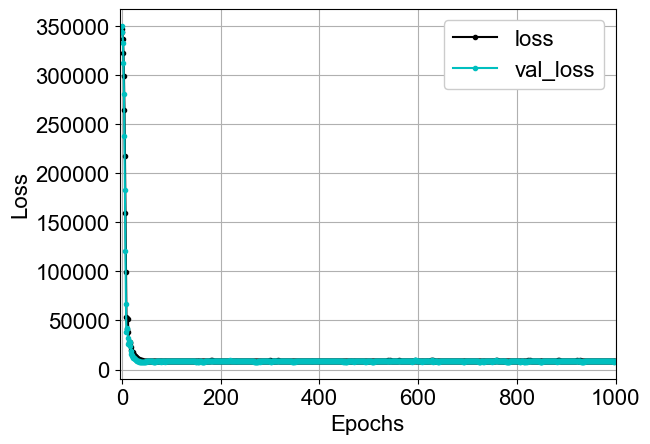

In [32]:
loss = Model.history['loss']
val_loss = Model.history['val_loss']
epochs = len(loss)
plt.xlim((-5, 1000))
plt.plot(range(epochs), loss, color = 'k', marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, color = 'c', marker = '.', label = 'val_loss')
plt.xticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.yticks(fontname="Arial", fontsize=16, fontweight='normal')
plt.legend(loc = 'best', framealpha=1, prop={'size': 16, 'family':"Arial"})

plt.grid()
plt.xlabel('Epochs',fontname="Arial", fontsize=16)
plt.ylabel('Loss',fontname="Arial", fontsize=16)
plt.savefig("FFNN_Loss.png", dpi=600, bbox_inches='tight')
plt.show()

In [33]:
filepath = 'MRI_DNN.model'
save_model(model, filepath, save_format='h5')

In [34]:
model = load_model('MRI_DNN.model')

In [35]:
y_pred_train = model.predict((x_train))
print("Train set R^2: %.2f" % r2_score(y_train, y_pred_train))
print("Train MAE score: %.2f" % mean_absolute_error(y_train, y_pred_train))
print("Train RMSE score: %.2f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = model.predict((x_test))
print("Test set R^2: %.2f" % r2_score(y_test, y_pred_test))
print("Test MAE score: %.2f" % mean_absolute_error(y_test, y_pred_test))
print("Test RMSE score: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Inconsistent ASTs detected. This is a bug. Cause: 
inconsistent values for field args: [<gast.gast.Name object at 0x00000204FA035850>] and []Diff:
*** Original nodes

--- Reparsed nodes

***************

*** 30,68 ****

  | | | ]
  | | | value=Constant:
  | | | | value=None
  | | | | kind=None
  | | FunctionDef:
  | | | name=u"inner_factory"
  | | | args=arguments:
! | | | | args=[
  | | | | | Name:
  | | | | | | id=u"ag__"
  | | | | | | ctx=Param()
  | | | | | | annotation=None
  | | | | | | type_comment=None
  | | | | ]
- | | | | posonlyargs=[]
  | | | | vararg=None
  | | | | kwonlyargs=[]
  | | | | kw_defaults=[]
  | | | | kwarg=None
  | | | | defaults=[]
  | | | body=[
  | | | | FunctionDef:
  | | | | | name=u"tf__predict_function"
  | | | | | args=arguments:
! | | | | | | args=[
  | | | | | | | Name:
  | | | | | | | 

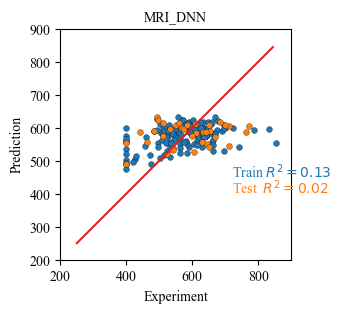

In [36]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)
plt.scatter(y_train, y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)
plt.scatter(y_test, y_pred_test, c='#ff7f0e', marker='o', s = 18, edgecolors='k', linewidths = 0.2) 

plt.xlabel("Experiment",fontname="Times New Roman", fontsize=10)
plt.ylabel("Prediction",fontname="Times New Roman", fontsize=10)
x0, x1 = min(y_train), max(y_train)
length = 600
x_start, x_end = 250, 850
plt.xlim([200, 900])
plt.ylim([200, 900])
# ax.set_xticks([-200,-100,0,100,200,300,400,500])
# ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), '#d62728')
plt.text(720, 450, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2)),{'color':'#1f77b4'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.text(720, 400, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':'#ff7f0e'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_DNN',fontname="Times New Roman", fontsize=10)
plt.savefig("Polyinfo_MRI_DNN.png", dpi=1200, bbox_inches='tight') 